In [1]:
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import numpy as np
import os
import copy
import unicodedata
import string
import re
import json

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

class RewardNet(nn.Module):
    def __init__(
        self, state_dim, output_mod=None):
        super().__init__()
        self.reward = nn.Sequential(
            nn.Linear(state_dim, state_dim), nn.ReLU(),
            nn.Linear(state_dim, state_dim), nn.ReLU(),
            nn.Linear(state_dim, 1)
        )
        self.pref = nn.Linear(2, 1)
        self.apply(weight_init)

    def forward(self, state1, state2):
        r1 = self.reward(state1)
        r2 = self.reward(state2)
        comp = torch.squeeze(torch.stack([r1,r2], dim=1))
        pref = self.pref(comp)
        return r1, r2, pref

In [97]:
state_dim = 18

reward_net = RewardNet(state_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reward_net.to(device)

RewardNet(
  (reward): Sequential(
    (0): Linear(in_features=18, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=1, bias=True)
  )
  (pref): Linear(in_features=2, out_features=1, bias=True)
)

In [98]:
import csv
with open('data/train_rewards500.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1 = []
    states2 = []
    prefs = []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[1,     1] loss: 0.75643617
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (

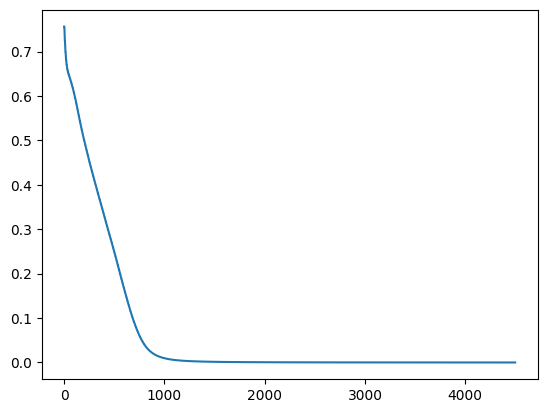

In [99]:
num_epochs = 750
batch_size = 100

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(reward_net.parameters()), lr=0.001)

losses = []

idxs = np.array(range(len(states1)))
num_batches = len(idxs) // batch_size

# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
   
        t_states1 = torch.Tensor(states1).float().to(device)
        t_states2 = torch.Tensor(states2).float().to(device)
        t_prefs = torch.Tensor(prefs).float().to(device).unsqueeze(1)

        pred_r1s, pred_r2s, pred_prefs = reward_net(t_states1, t_states2)
        loss = criterion(pred_prefs, t_prefs)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

torch.save(reward_net, 'reward_network.pt')
print('Finished Training')
plt.plot(losses)
plt.savefig('losses.png')

In [100]:
reward_net = torch.load('reward_network.pt')
reward_net.eval()

import csv
with open('data/test_rewards.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1 = []
    states2 = []
    prefs = []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)

num_correct = 0.0
for n in range(len(states1)):
    state1 = torch.Tensor(states1[n]).to(device)
    state2 = torch.Tensor(states2[n]).to(device)
    pred_r1, pred_r2, pred_pref = reward_net(state1, state2)
    pred_pref = pred_pref.cpu().detach().numpy()[0]
    if pred_pref > 0 and prefs[n] == 1:
        num_correct+=1
    elif pred_pref <= 0 and prefs[n] == 0:
        num_correct+=1

accuracy = num_correct / len(states1)
print("Percent correct: %f " % accuracy)

Percent correct: 0.930000 


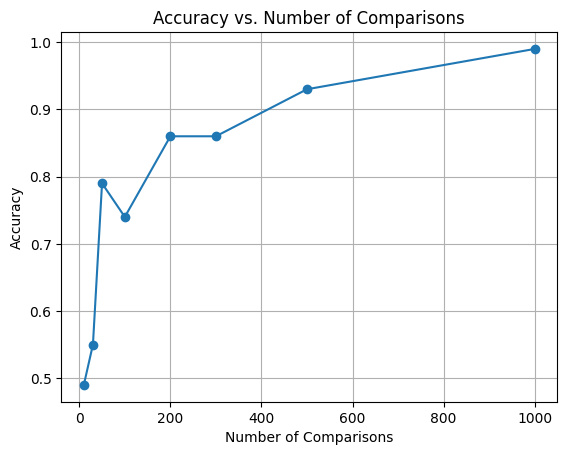

In [102]:
num_samples = [10, 30, 50, 100, 200, 300, 500, 1000]
accuracy = [0.49, 0.55, .79, 0.74, 0.86, 0.86, 0.93, 0.99]

plt.plot(num_samples, accuracy, marker='o')
plt.xlabel('Number of Comparisons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Comparisons')
plt.grid(True)
plt.show()